# EURUSD prediction

## Dependencies

In [3]:
from database_operations.DatabaseManager import DatabaseManager
from scripts.HistoricalDataCollector import HistoricalDataCollector
from xapi import PeriodCode
from my_secrets import config

import pandas as pd

### Connection to database and define symbol

In [4]:
SYMBOL = "EURUSD"
database_conn = DatabaseManager(config.DB_FILE)

In [5]:
SYMBOL_ID  = await database_conn.get_specify_data("stock",["id"], f"symbol = ?",(SYMBOL,))
SYMBOL_ID = SYMBOL_ID[0][0]

Connected to db.
Set row factory.


## Download newest EURUSD data and save in db

In [6]:
hist_data_collector = HistoricalDataCollector(
    symbol= SYMBOL,
    start='2000-01-01',
    end='2023-10-10',
    period=PeriodCode.PERIOD_D1,
    credentials_file=config.CREDENTIALS_PATH
)
await hist_data_collector.connect_to_xapi()
await database_conn.populate_prices("stock_price_1d", SYMBOL_ID, SYMBOL, hist_data_collector)

Connected to API.
Last date in the database
2023-10-12 00:00:00
Today's date
2023-10-19 00:00:00
Newest data downloaded
Data for symbol: EURUSD just added to the database.
Disconnected from db.


## Download data from db

In [7]:
COLUMNS = ['date', 'open', 'close', 'high', 'low', 'volume']
columns_with_prefix = [f'sp.{column}' for column in COLUMNS]
columns_list = ', '.join(columns_with_prefix)

In [8]:
QUERY = f"""
        SELECT {columns_list}
        FROM stock s
        JOIN stock_price_1d sp ON s.id = sp.stock_id
        WHERE s.symbol = ?
        """

In [9]:
data_list = await database_conn.execute_custom_query(QUERY, (SYMBOL,))

Connected to db.
Set row factory.


## Create dataframe

In [10]:
data_df = pd.DataFrame(data_list, columns=COLUMNS)

In [11]:
data_df['date'] = data_df['date'].str.split(' ').str[0]

In [12]:
data_df['date'] = pd.to_datetime(data_df['date'])

In [13]:
data_df.set_index('date',inplace=True)

<Axes: xlabel='date'>

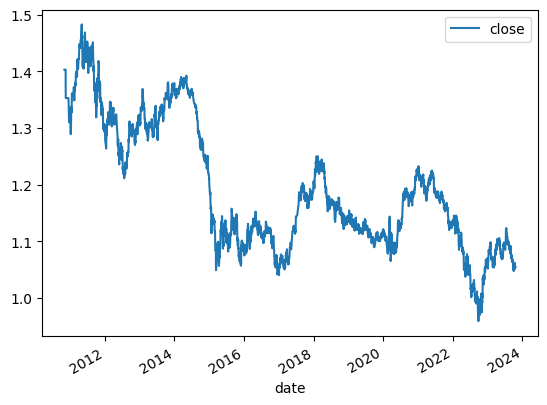

In [14]:
data_df.plot.line(y="close",use_index=True)

# Reinforcement Learning

In [18]:
!pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/80/6f/57d36f6507e432d7fc1956b2e9e8530c5c2d2bfcd8821bcbfae271cd6688/tensorflow-2.14.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.14.0 from https://files.pythonhosted.org/packages/ad/6e/1bfe367855dd87467564f7bf9fa14f3b17889988e79598bc37bf18f5ffb6/tensorflow_intel-2.14.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl.metadata (850 bytes)
     ----------------------------------------

In [24]:
!pip install gymnasium

  Obtaining dependency information for gymnasium from https://files.pythonhosted.org/packages/a8/4d/3cbfd81ed84db450dbe73a89afcd8bc405273918415649ac6683356afe92/gymnasium-0.29.1-py3-none-any.whl.metadata
  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
  Using cached cloudpickle-2.2.1-py3-none-any.whl (25 kB)
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)


In [27]:
!pip install stable-baselines3

In [1]:
!pip install tensorflow[and-cuda]

In [1]:
!pip install gym-anytrading

  Obtaining dependency information for gym-anytrading from https://files.pythonhosted.org/packages/31/97/1c92ae872371577fb4e732ec1365775fa12ce2865233909b5d10dc4f19df/gym_anytrading-2.0.0-py3-none-any.whl.metadata
  Using cached gym_anytrading-2.0.0-py3-none-any.whl.metadata (292 bytes)
Using cached gym_anytrading-2.0.0-py3-none-any.whl (172 kB)



[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import gymnasium as gym
import gym_anytrading

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [19]:
data_df = data_df.rename(columns=lambda x: x.capitalize())

In [20]:
env = gym.make('stocks-v0', df=data_df, frame_bound=(5,100), window_size=5)

In [21]:
env.signal_features

C:\Users\jkwia\OneDrive\Pulpit\DYSK PC\Code Proj\GITHUB\XTB_Trading\venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.signal_features to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.signal_features` for environment variables or `env.get_wrapper_attr('signal_features')` that will search the reminding wrappers.
  logger.warn(


array([[ 1.403090e+00,  0.000000e+00],
       [ 1.403090e+00, -2.220446e-16],
       [ 1.352900e+00, -5.019000e-02],
       [ 1.352900e+00,  0.000000e+00],
       [ 1.311930e+00, -4.097000e-02],
       [ 1.310280e+00, -1.650000e-03],
       [ 1.310960e+00,  6.800000e-04],
       [ 1.311540e+00,  5.800000e-04],
       [ 1.311280e+00, -2.600000e-04],
       [ 1.316230e+00,  4.950000e-03],
       [ 1.310880e+00, -5.350000e-03],
       [ 1.321670e+00,  1.079000e-02],
       [ 1.329060e+00,  7.390000e-03],
       [ 1.335080e+00,  6.020000e-03],
       [ 1.315010e+00, -2.007000e-02],
       [ 1.300200e+00, -1.481000e-02],
       [ 1.290860e+00, -9.340000e-03],
       [ 1.289280e+00, -1.580000e-03],
       [ 1.294580e+00,  5.300000e-03],
       [ 1.297370e+00,  2.790000e-03],
       [ 1.312810e+00,  1.544000e-02],
       [ 1.334760e+00,  2.195000e-02],
       [ 1.337270e+00,  2.510000e-03],
       [ 1.337000e+00, -2.700000e-04],
       [ 1.327580e+00, -9.420000e-03],
       [ 1.338460e+00,  1

## Build enviroment

In [22]:
env.action_space

Discrete(2)